In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as ml
import matplotlib.pyplot as plt
import datetime

trajectory = 'DE-HG2'

In [2]:
rawLinks = pd.read_csv('MOCA-data/10090.protein.links.full.v11.0.CombinedScore.HighConfidence.csv')
rawAlias = pd.read_csv('MOCA-data/10090.protein.aliases.v11.0.UniProt.csv')
print('Here')
print(str(datetime.datetime.now()))

Here
2019-03-25 16:03:11.365089


In [3]:
#build a map of proteinId in rawLinks to gene product names
proteinIdToAlias = {}
aliasToProteinId = {}
duplicatedAliases = []
for val in list(zip(rawAlias.string_protein_id, rawAlias.alias)):
    if val[1] in aliasToProteinId:
        duplicatedAliases.append(str(val[1]))
        aliasToProteinId[val[1]].append(val[0])
    else:
        aliasToProteinId[val[1]] = [val[0]]
    
    if not val[0] in proteinIdToAlias: #the alias file has lots of duplicates!
        proteinIdToAlias[val[0]]=[val[1]]
    else:
        proteinIdToAlias[val[0]].append(val[1])
        
print('Here')
print('There are ', len(duplicatedAliases), ' aliases which point to multiple protein ids')
print(str(datetime.datetime.now()))

Here
There are  0  aliases which point to multiple protein ids
2019-03-25 16:03:11.474174


In [4]:
#build the list of links mapped to gene product name
links = list(zip(rawLinks.protein1, rawLinks.protein2, rawLinks.combined_score))
links = [list(elem) for elem in links]
print('Here')
print(str(datetime.datetime.now()))

Here
2019-03-25 16:03:12.142461


In [5]:
#read in the gene list and build the acceptable set
print(str(datetime.datetime.now()))
rawGeneList = pd.read_csv('MOCA-data/41586_2019_933_MOESM4_ESM.csv')
genesByTrajectory = {};
clusterForGene = {};
for index, row in rawGeneList.iterrows():
    traj = row.trajectory;
    mgi = row.mgi.upper();
    cluster = row.cluster;
    
    clusterForGene[mgi] = cluster
    
    if traj in genesByTrajectory:
        genesByTrajectory[traj].append({'mgi': mgi, 'cluster': cluster});
    else:
        genesByTrajectory[traj] = [{'mgi': mgi, 'cluster': cluster}];

acceptableGeneSet = set(map(lambda x: x['mgi'], genesByTrajectory[trajectory]))
print(str(datetime.datetime.now()))

2019-03-25 16:03:12.149720
2019-03-25 16:03:12.356217


In [6]:
#filter links where both in and out are in the dataset
print(str(datetime.datetime.now()))
print('There are ', len(acceptableGeneSet), ' acceptable gene products')

print('Determining gene products which have multiple protein ids')
problematic = list(acceptableGeneSet.intersection(duplicatedAliases))
print('There are ', len(problematic), ' aliases which have multiple protein ids');

filteredLinks = []
for link in links:
    aliasesOfStart = proteinIdToAlias[link[0]]
    aliasesOfEnd = proteinIdToAlias[link[1]]
     
    startIsAcceptable = not acceptableGeneSet.isdisjoint(aliasesOfStart)
    endIsAcceptable = not acceptableGeneSet.isdisjoint(aliasesOfEnd)
    
    if startIsAcceptable and endIsAcceptable:
        filteredLinks.append(link)
        
print('There are ', len(filteredLinks), ' filtered links')
print(str(datetime.datetime.now()))

2019-03-25 16:03:12.362112
There are  1258  acceptable gene products
Determining gene products which have multiple protein ids
There are  0  aliases which have multiple protein ids
There are  6538  filtered links
2019-03-25 16:03:12.896850


In [7]:
#transform filtered links to not use protein ids but rather aliases (or a combination)
print('Transform the filtered links...')
print(str(datetime.datetime.now()))
for geneProduct in acceptableGeneSet:
    if not geneProduct in aliasToProteinId:
        continue
        
    proteinIds = aliasToProteinId[geneProduct]
    for proteinId in proteinIds:
        for link in filteredLinks:
            if link[0] == proteinId:
                link[0] = geneProduct
            
            if link[1] == proteinId:
                link[1] = geneProduct

print('Done...')
print(str(datetime.datetime.now()))

Transform the filtered links...
2019-03-25 16:03:12.903455
Done...
2019-03-25 16:03:14.022945


In [8]:
print(str(datetime.datetime.now()))
G = nx.DiGraph()
G.add_weighted_edges_from(filteredLinks)

clusters = {}

for n in G.nodes:
    clusters[n] = clusterForGene[n]

nx.set_node_attributes(G, clusters, 'cluster');

nx.write_gml(G, 'out/gephi/moca' + trajectory + '.gml')
print('Now open out/gephi/moca' + trajectory + '.gml')
print(str(datetime.datetime.now()))

2019-03-25 16:03:14.028985
Now open out/gephi/mocaDE-HG2.gml
2019-03-25 16:03:14.084063


(array([ 546.,  396.,  324.,  344.,  302.,  302., 1578., 1102.,  608.,
        1036.]),
 array([701. , 730.8, 760.6, 790.4, 820.2, 850. , 879.8, 909.6, 939.4,
        969.2, 999. ]),
 <a list of 10 Patch objects>)

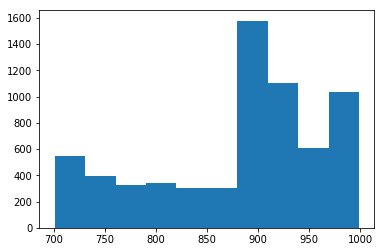

In [9]:
weights = []
for link in filteredLinks:
    weights.append(link[2])
    
plt.hist(weights)